### 实现思路/灵感：
...基于不同类型客户的具体需求、行为和兴趣点，企业可以调整产品，以更好地满足客户需求。最终目标是构建一个理想客户匹配模型。 本模型计划界定客户群体，以确定并设计不同的营销策略。

用户群体的界定暂时想到两个想法：
<br><b>1. 依据用户生命周期（导入期、成长期、成熟期、休眠期和已流失）。如此做则需要为每个周期关注不同的指标</b>
<br><b>2. 依据RFM模型对客户分级。如此做将更重点关注消费数据，个人认为对数据集的利用不足。</b>
<br>

记录问题：

1. 这种设计思路是否是有效/符合行业逻辑的，是否需要更深一步的考虑？


### 模型实现计划（以简述文件为基，根据个人习惯稍作排序）
#### 一、数据探索分析
#### 1.1 ETL 预处理
1. 去除无意义列、空值、过多重复的连续性变量（可能不适用）；
2. 对性别、婚姻情况，对5次优惠活动的接受状态等<b><i>离散指标</i></b>转换为dummy变量；
3. 切除异常值并确立取样范围；设计衍生变量。

<br>
记录问题：


1. 去空值时，是否有必要考虑“此处数据为何为空，是否与其他指标存在关系”？

2. 设计衍生值时，根据出生年（birth）衍生年龄（age）是否存在数据时效性的问题？
    - 每年为此都更新一次？或是在运用出生年的函数中使用公式代替衍生列？
#### 1.2 特征工程 
1. 计算通用的分析指标。还需根据“实现思路”中的方向，整合需要设计的指标；
2. 观察列之间的关系。例如：
    - 符合直觉的：婚姻状态 -> 糖果/黄金支出？年龄 -> 更偏爱的购买方式（网站/商店）？
    - 需要深入探索的：A -> B呈明显的正相关？
        - 想挖掘此类关系，是否需要对连续型变量进行大量可视化？
3. 可以考虑使用部分离散指标（如受教育程度、注册时间等）建立用户画像。（但它在模型的建立上可以贡献什么？）
                
<br>
记录问题：


1. 我是否可以根据每列的数据的类型，将其标注为“描述不同维度的指标”？比如，以人货场模型的概念为出发点，为每列数据标注“人、货、场”的标签？
    - 由于尚未亲历过商业报告以实践理论知识，我对模型理论的应用是否有所偏差——或者是我想太复杂了，关注“实现思路”中的指标就够了，不需要引入其他模型？
2. 想挖掘更多的数据相关性，是否需要对连续型变量进行大量可视化？
    - 例如，为每列连续指标都绘制折线图、点图来直观化分布和趋势，再对比哪些图之间具有相关性？在一般的数据分析工作中，一般是否需要进行此类工作？
3. 如何合理的安排<b><i>数据特征</i></b>和<b><i>离散指标</i></b>去建立模型？
    - 打算建立一个无监督的分类模型，没有训练数据的情况下不太敢一股脑把所有列都丢进去
    
#### 1.3 模型建立
<i>由于课题的最终目标是构建一个理想客户匹配模型</i>，使用无监督模型更符合需求。

聚类算法（K-mean，层次聚类等）、降维算法（PCA）都可以满足需求，但是避免过拟合需要考虑结合多种模型。此外，评估模型表现需要使用决策树和森林等..（施工中）

In [59]:
import pandas as pd
from datetime import datetime
import numpy as np
import re
import nltk
import random
import time
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [60]:
df = pd.read_csv("custom_data.csv")
df2 = df.copy()
#去除索引列、用户id列，将RegisterDate的格式更为timestamp
df2 = df2.drop(columns=['Unnamed: 0','ID']).dropna()
df2['RegisterDate'] = pd.to_datetime(df['RegisterDate'], format='%d-%m-%Y')

#根据Birth，衍生Age，衍生总支出，衍生总购买次数，将Edu,married列哑变量化
df2['Age'] = datetime.now().year - df['Birth']
df2 = df2.drop(columns=['Birth'])
df2['TotalPay'] = df2['WinesPay']+df2['FruitsPay']+df2['MeatProductsPay']+df2['FishProductsPay']+df2['SweetProductsPay']+df2['GoldProdsPay']
df2['TotalPurchaseNum'] = df2['WebPurchasesNum']+df2['CatalogPurchasesNum']+df2['StorePurchasesNum']
df3 = df2.copy()
df3 = pd.get_dummies(df3,columns = ['Edu','Married'])


In [61]:
df3.columns

Index(['Income', 'Kidnum', 'Teennum', 'RegisterDate', 'PurchaseDays',
       'WinesPay', 'FruitsPay', 'MeatProductsPay', 'FishProductsPay',
       'SweetProductsPay', 'GoldProdsPay', 'DealsPurchasesNum',
       'WebPurchasesNum', 'CatalogPurchasesNum', 'StorePurchasesNum',
       'WebVisitsMonthNum', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complaint', 'Response', 'Age',
       'TotalPay', 'TotalPurchaseNum', 'Edu_2n Cycle', 'Edu_Basic',
       'Edu_Graduation', 'Edu_Master', 'Edu_PhD', 'Married_Absurd',
       'Married_Alone', 'Married_Divorced', 'Married_Married',
       'Married_Single', 'Married_Together', 'Married_Widow', 'Married_YOLO'],
      dtype='object')

Text(0.5, 1.0, 'Scatter Plot of TotalPurchaseNum')

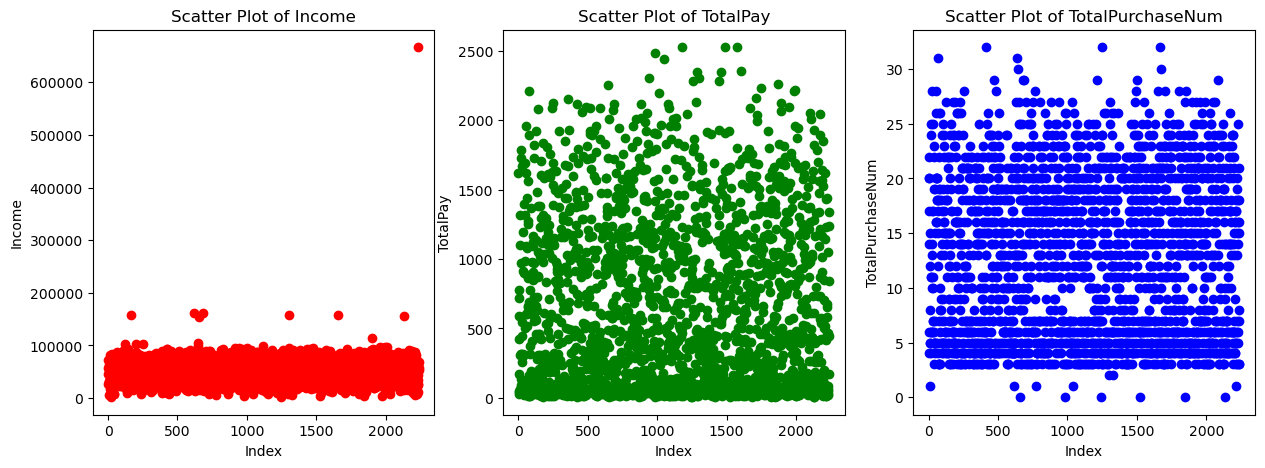

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# scatter plot to show the distribution of post_retweets
axs[0].scatter(df3.index, df3['Income'], color='r')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Income')
axs[0].set_title('Scatter Plot of Income')

# scatter plot to show the distribution of post_quotes
axs[1].scatter(df3.index, df3['TotalPay'],color='g')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('TotalPay')
axs[1].set_title('Scatter Plot of TotalPay')
# scatter plot to show the distribution of user_mentions
axs[2].scatter(df3.index, df3['TotalPurchaseNum'], color='b')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('TotalPurchaseNum')
axs[2].set_title('Scatter Plot of TotalPurchaseNum')

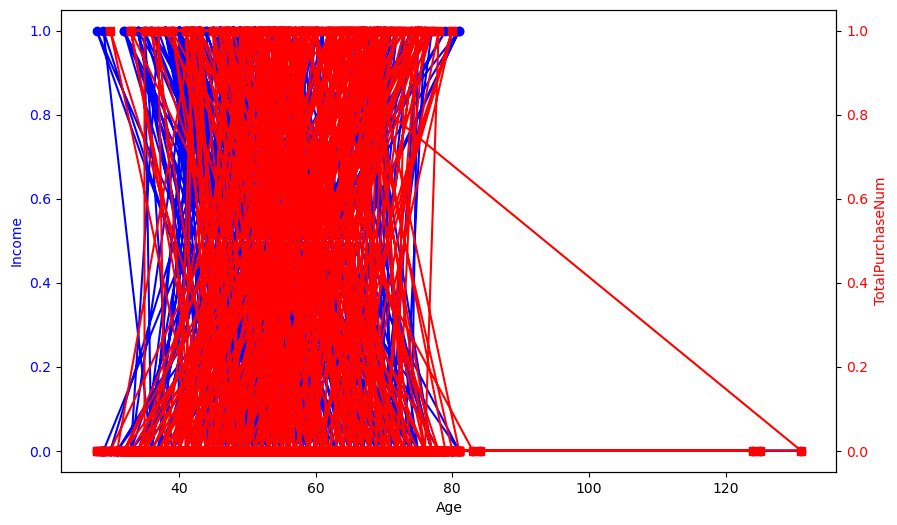

In [79]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制第一个数据系列（Sales_A）
ax1.plot(df3.Age, df3['AcceptedCmp3'], marker='o', color='b', label='Income')
ax1.set_xlabel('Age')
ax1.set_ylabel('Income', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()  
ax2.plot(df3.Age, df3['AcceptedCmp4'], marker='s', color='r', label='TotalPurchaseNum')
ax2.set_ylabel('TotalPurchaseNum', color='r')
ax2.tick_params(axis='y', labelcolor='r')
#多看看matplot可视化教程

#### （灵感留存）用户数据可以以人货场模型的思路分为三类：
#### 1. 基础信息（人），用户本人及其家庭的基础概况：  
['Birth','Edu','Married','Income','Kidnum','Teennum']
#### 2. 消费数据（货），即为用户于特定平台内的消费记录埋点及数据：
['RegisterDate','PurchaseDays','WinesPay','FruitsPay','MeatProductsPay','FishProductsPay','SweetProductsPay','GoldProdsPay']
#### 3. 日活数据（场），用户使用产品时对功能的埋点数据：
['DealsPurchasesNum','WebPurchasesNum','CatalogPurchasesNum','StorePurchasesNum', 'WebVisitsMonthNum', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Complaint','Response']
